# Load Doggo trained model and plot results

Baseline model to load in models. Please change code accordingly to load in your model...

## Setup

In [1]:
import tensorflow as tf
import matplotlib as mpl
from matplotlib import pyplot as plt
from tensorflow import keras

import  numpy as np
import pandas as pd

import matplotlib.colors as mcol

import time 
import os

import glob

In [2]:
plt.rcParams['figure.figsize'] = [9, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [26]:
#from google.colab import drive
#drive.mount('/gdrive')

Comment out if don't need

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


# Load the Model

In [4]:
new_model = tf.keras.models.load_model('doggo_Trained_Model', compile=False) # Change load checkpoint
new_model.summary()

Model: "Koopman_AE_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_model_10 (EncoderMod multiple                  8480      
_________________________________________________________________
koopman__model_10 (Koopman_M multiple                  256       
_________________________________________________________________
decoder_model_10 (DecoderMod multiple                  9700      
Total params: 18,436
Trainable params: 18,436
Non-trainable params: 0
_________________________________________________________________


## Load data

In [5]:
doggo_train = pd.read_csv('Mulch Soil Data/train_data.csv', sep=',').values
doggo_test =pd.read_csv('Mulch Soil Data/test_data.csv', sep=',').values
doggo_validation = pd.read_csv('Mulch Soil Data/validation_data.csv', sep=',').values

In [6]:
doggo_train = doggo_train[:,0:4]
doggo_test = doggo_test[:,0:4]
doggo_validation = doggo_validation[:,0:4]

In [7]:
trajLength = 25 #length of each trajectory in the dataset
numTraj = 32 #total number of trajectories in the dataset
numTraj_val = 8
batch_size = int(32) # Number of snapshots in each batch
numTraj_batch = int(batch_size/trajLength)
input_dim = 4

num_batches_train = int(trajLength*numTraj/batch_size) ## num_batches = trajLength*numTraj/batch_size 
num_batches_val = int(trajLength*numTraj_val/batch_size)

### Preprocess Data

In [8]:
# Normalize the data
min_val = tf.reduce_min(doggo_train)
max_val = tf.reduce_max(doggo_train)

# scale -1 to 1
doggo_train = 2 * (doggo_train - min_val) / (max_val - min_val) - 1
doggo_validation = 2 * (doggo_validation - min_val) / (max_val - min_val) - 1
doggo_test = 2 * (doggo_test - min_val) / (max_val - min_val) - 1

train_data = tf.cast(doggo_train, tf.float32)
validation_data = tf.cast(doggo_validation, tf.float32)
validation_data = tf.data.Dataset.from_tensor_slices((validation_data, validation_data)).batch(batch_size)
test_data = tf.cast(doggo_test, tf.float32)

In [9]:
x_train = train_data
y_train = train_data

tf.shape(x_train)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([832,   4])>

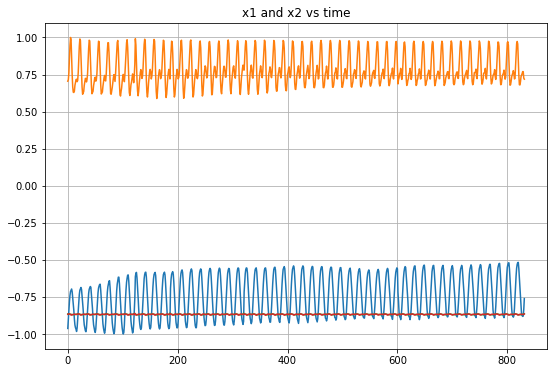

In [10]:
trail = train_data[trajLength*100:trajLength*110,:]
plt.grid()
plt.plot(x_train) #51 samples for each trajectory
plt.title("x1 and x2 vs time")
plt.show()

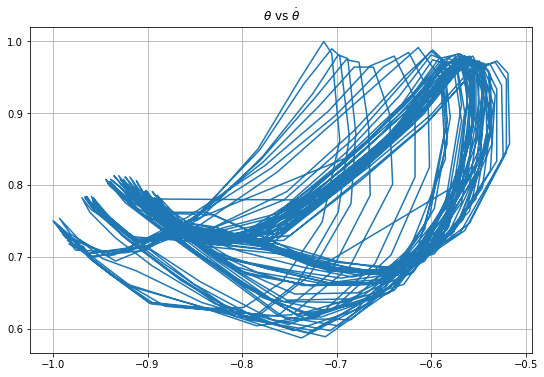

In [11]:
plt.grid()
plt.plot(train_data[:,0], train_data[:,1]) #51 samples for each trajectory
plt.title(r"$\theta$ vs $\dot \theta$")
plt.show()

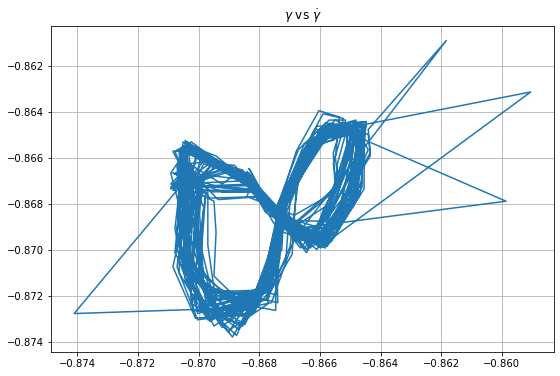

In [12]:
plt.grid()
plt.plot(train_data[:,2], train_data[:,3]) #51 samples for each trajectory
plt.title(r"$\gamma$ vs $\dot \gamma$")
plt.show()

# Plots on Test Data

In [15]:
input = test_data
reconstruction, preditcion, prediction_linear = new_model(input)

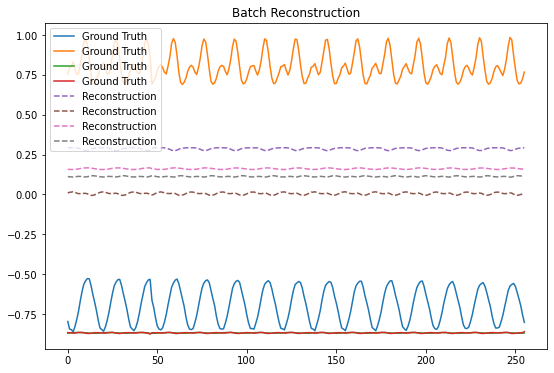

In [16]:
plt.title("Batch Reconstruction")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(input, label = "Ground Truth")
plt.plot(reconstruction, '--', label="Reconstruction")
plt.legend()

In [18]:
x = input
x2 = []
for i in range(numTraj_batch):
    x2.append(x[i*trajLength+1:(i+1)*trajLength])
x2 = tf.reshape(x2, [-1, x.shape[-1]]) # Shifted input

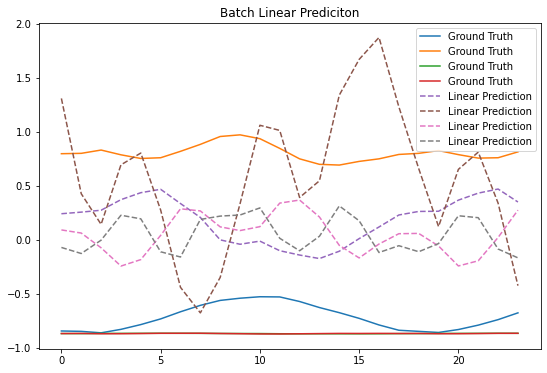

In [19]:
plt.title("Batch Linear Prediciton")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(x2, label = "Ground Truth")
plt.plot(prediction_linear, '--', label="Linear Prediction")
plt.legend()

In [42]:
K = new_model.koopman.get_weights()
print(tf.squeeze(K))

tf.Tensor(
[[ 0.04680064 -0.07271696  0.07890263 ...  0.05840349 -0.05957182
  -0.01118766]
 [-0.00346375  0.03452671  0.04423199 ...  0.01445156  0.04320152
   0.07154302]
 [-0.01876942  0.02378536  0.17800158 ... -0.1042107  -0.10070596
  -0.01008614]
 ...
 [ 0.11970284  0.00682904 -0.10966741 ... -0.00312475 -0.07961027
  -0.0906732 ]
 [-0.1888253   0.00971654 -0.0019805  ... -0.01352336 -0.01327515
   0.07654688]
 [ 0.00674055  0.00717725 -0.08447197 ...  0.03076993  0.0401029
   0.01670591]], shape=(32, 32), dtype=float32)
